In [3]:
import os
import numpy as np
import pickle
import pandas as pd
from scipy.stats import zscore
from brainbox.io.one import SessionLoader
from sklearn.preprocessing import StandardScaler
import gc
import concurrent.futures

from functions import merge_licks, resample_common_time, interpolate_nans, low_pass
from one.api import ONE
one = ONE(mode='remote')

In [4]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [4]:
""" Load BWM data post-QC """

data_path = prefix + '/representation_learning_variability/paper-individuality/'
filename = '1_bwm_qc_07-10-2025'



data_path = prefix + 'representation_learning_variability/Video and wheel/Video QC/'
filename = 'final_lp_qc07-10-2025'


bwm_query = pickle.load(open(data_path+filename, "rb"))


/tmp/ipykernel_10759/431073403.py:13: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  bwm_query = pickle.load(open(data_path+filename, "rb"))


In [5]:
extra_sessions = ['2d7c0f7f-e805-404b-914a-23d83998e08e',
'7691eeb3-715b-4571-8fda-6bb57aab8253',
'a28746ff-a6e0-403d-a11d-893c2f9a44b4',
'f140a2ec-fd49-4814-994a-fe3476f14e66',
'bd8b204f-a42e-45c1-a8f0-71c6223a6657',
'e4fac833-d985-4bb2-a97a-c4d7ed8d06e1',
'13b70283-e8d3-4e69-ae3f-83f50c9602e2',
'e34ee0ad-3ad8-4faa-b4d5-c1cc0cf3b496',
'f3eeb2d4-87ce-49ae-8a74-21665f6f1536',
'd9f0c293-df4c-410a-846d-842e47c6b502',
'86f741b4-9dee-4c28-8ee9-49f3656ab419',
'650a0a90-4bf3-4489-9bcd-75baf0a49eac',
'a2be3311-de26-48b3-bfc7-317e94a4fdd3',
'12f95449-6914-4d76-9eb3-7d79757a4a77',
'd9907ac3-7378-471d-91fb-c8ec34870e17',
'b4a8ec28-46ad-4b6f-908b-650d0970a0db',
'c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9',
'71963e7f-5947-4c3e-bcc8-dfdef3d71be7',
'7471a326-894d-4b55-8b01-a0ad56af209c',
'8839a67d-991a-4694-9c45-b3af73ce4d36',
'db4fe6df-b1d2-4958-9c93-e71696d58f7f',
'80653a5b-c7aa-479d-9ae0-c92f296fface',
'169c9a39-cb63-4b77-93e2-10e076d4c472',
'495bee7e-b58e-42ea-8481-4a1bfedca54a',
'1db57661-5ad3-4465-b9ee-08473af9c2e8',
'3513e7f2-d2e6-4411-8055-54dac50458f6',
'd035c5ba-d51e-49a9-a94b-23531a598ec3',
'6a369bfa-a70b-4147-af25-d03772ff8d96',
'7050ae29-a99e-43f1-aa42-b4416200351c',
'3fa080ff-bcce-43e8-bd5f-601f0591f785',
'369c3073-e886-4b28-a32b-a5860df21392',
'aa8c915b-cc12-4022-8339-3faa438d7fe2',
'8b422ab2-fc98-4d25-ac1f-e239ca869d9e',
'87d86bb0-72d3-4213-be72-392295d3d601',
'2ab80a04-96f6-45f8-bf69-7eac67f81742',
'57701dff-8107-4ab6-ac7a-b087a2e4cc94',
'42541dce-2ffb-452e-bf54-119aee2ae48a',
'89848cb4-77d3-4db2-877e-2fa73a3cf5f6',
'33cbe984-deb7-489c-add6-d98ac9f64df6',
'0b5f5111-5647-4400-8e08-f57975027b5e',
'9e77877d-6fcf-4e91-9337-4b19277561d5',
'dc36f1b9-5dba-49c4-b333-ad08af6b8f86',
'8a039e2b-637e-45ed-8da6-0641924626f0',
'00d3c9ea-2c91-44c2-b03e-6dfec5e08f27',
'e698b903-98ed-48b9-bc40-664274f722da',
'e5094e8a-cd54-43d4-8a7a-c5aa54b15e19',
'09137957-7216-40ea-90b5-ef85a62b578a',
'03f0ed7f-e647-4732-ae1a-d41fc459138b',
'4373de88-6b08-4185-a224-f898fd0017d4',
'30c4e2ab-dffc-499d-aae4-e51d6b3218c2',
'1e07df0b-205b-4c94-8e02-2ae07dae4347',
'5c7d2345-1f0e-40e5-aad7-2c6133b71b09',
'1735d2be-b388-411a-896a-60b01eaa1cfe',
'14736609-bfdd-4620-8e47-09d7f4bc4412',
'4537bd9a-0a63-4462-870c-5f6d70d289ed',
'1715d2bc-4da3-4de2-9631-3ab1c600f2bf',
'aed404ce-b3fb-454b-ac43-2f12198c9eaf',
'f115196e-8dfe-4d2a-8af3-8206d93c1729',
'5c454bcb-ae77-42da-a8d2-b6463ea9f21b',
'c728f6fd-58e2-448d-aefb-a72c637b604c',
'c8fc81e8-fd09-4228-a08c-81c01f21381a',
'7502ae93-7437-4bcd-9e14-d73b51193656',
'297bd519-78f8-45d2-af85-835e865e228f',
'7b074b1a-6576-4380-91e4-ad6cdf06c3a6',
'064a7252-8e10-4ad6-b3fd-7a88a2db5463']

In [6]:
# Loop through animals
# sessions = bwm_query['eid'].unique()
sessions = extra_sessions

data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/extra_bwm/'
os.chdir(data_path)
files = os.listdir()
sessions_to_process = []

for s, sess in enumerate(sessions):
    file_path = one.eid2path(sess)

    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    filename = "design_matrix_" + str(sess) + '_'  + mouse_name
    if filename not in files:
        sessions_to_process.append((sess))

len(sessions_to_process)

58

In [7]:
paw_states = True

In [8]:
    session = sessions_to_process[0]
    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    sl.load_session_data(trials=True, wheel=True, motion_energy=True)

    # Check if all data is available
    if np.sum(sl.data_info['is_loaded']) >= 4:

        # Poses
        poses = sl.pose
        lc_t = np.asarray(poses['leftCamera']['times'])
        rc_t = np.asarray(poses['rightCamera']['times'])
        left_fr = int(1/np.nanmean(np.diff(lc_t)))
        right_fr = int(1/np.nanmean(np.diff(rc_t)))
        
        # Motion energy
        me = sl.motion_energy
        mel_t = lc_t
        mer_t = rc_t
        motion_energy_l = interpolate_nans(me['leftCamera']['whiskerMotionEnergy'], left_fr)
        motion_energy_r = low_pass(interpolate_nans(me['rightCamera']['whiskerMotionEnergy'], right_fr), 
                                          cutoff=30, sf=right_fr)
        # Licks
        features = ['tongue_end_l_x', 'tongue_end_l_y', 'tongue_end_r_x', 'tongue_end_r_y']
        lick_t, licks = merge_licks(poses, features, common_fs=150)
        # Paws      
        l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], left_fr)
        l_paw_y = interpolate_nans(poses['leftCamera']['paw_r_y'], left_fr)
        r_paw_x = low_pass(interpolate_nans(poses['rightCamera']['paw_r_x'], right_fr), 
                                          cutoff=30, sf=right_fr)
        r_paw_y = low_pass(interpolate_nans(poses['rightCamera']['paw_r_y'], right_fr), 
                                          cutoff=30, sf=right_fr)
        l_paw_t = lc_t
        r_paw_t = rc_t
        # Wheel
        wheel = sl.wheel
        wheel_t = np.asarray(wheel['times'], dtype=np.float64)
        wheel_vel = wheel['velocity'].astype(np.float32)
        # Paw states
        if paw_states:
            times_l = one.load_dataset(session, '_ibl_%sCamera.times.npy' % 'left')
            times_r = one.load_dataset(session, '_ibl_%sCamera.times.npy' % 'right')
            assert np.all(lc_t==times_l)
            assert np.all(rc_t==times_r)
            paws_l = one.load_dataset(session, '_ibl_%sCamera.pawstates.pqt' % 'left')
            paws_r = one.load_dataset(session, '_ibl_%sCamera.pawstates.pqt' % 'right')


        # Common resampling window
        onset = max(lc_t.min(), rc_t.min(), wheel_t.min(), lick_t.min())
        offset = min(lc_t.max(), rc_t.max(), wheel_t.max(), lick_t.max())
        fs = 60
        ref_t = np.arange(onset, offset, 1 / fs, dtype=np.float64)

        # Restrict to time window
        def restrict(t, x):
            mask = (t >= onset) & (t <= offset)
            return t[mask], x[mask]

        mel_t, motion_energy_l = restrict(mel_t, motion_energy_l)
        mer_t, motion_energy_r = restrict(mer_t, motion_energy_r)
        wheel_t, wheel_vel = restrict(wheel_t, wheel_vel)
        l_paw_t_x, l_paw_x = restrict(l_paw_t, l_paw_x)
        l_paw_t_y, l_paw_y = restrict(l_paw_t, l_paw_y)
        r_paw_t_x, r_paw_x = restrict(r_paw_t, r_paw_x)
        r_paw_t_y, r_paw_y = restrict(r_paw_t, r_paw_y)
        lick_t, licks = restrict(lick_t, licks)


        # Resample
        mel_down, rt = resample_common_time(ref_t, mel_t, motion_energy_l, kind='linear')
        mer_down, _ = resample_common_time(ref_t, mer_t, motion_energy_r, kind='linear')
        wh_down, _ = resample_common_time(ref_t, wheel_t, wheel_vel, kind='linear')
        lk_down, _ = resample_common_time(ref_t, lick_t, licks, kind='nearest')
        lpx_down, _ = resample_common_time(ref_t, l_paw_t_x, l_paw_x, kind='linear')
        lpy_down, _ = resample_common_time(ref_t, l_paw_t_y, l_paw_y, kind='linear')
        rpx_down, _ = resample_common_time(ref_t, r_paw_t_x, r_paw_x, kind='linear')
        rpy_down, _ = resample_common_time(ref_t, r_paw_t_y, r_paw_y, kind='linear')


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 91.4M/91.4M [00:05<00:00, 17.6MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 3.48M/3.48M [00:01<00:00, 2.37MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 203M/203M [00:12<00:00, 15.9MB/s] 

2026-02-17 17:56:20 INFO     one.py:1288 Loading trials data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 7.78k/7.78k [00:00<00:00, 23.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 3.95k/3.95k [00:00<00:00, 9.29kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 3.95k/3.95k [00:00<00:00, 11.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_trials.table.pqt: 100%|██████████| 41.4k/41.4k [00:00<00:00, 85.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 3.95k/3.95k [00:00<00:00, 11.7kB/s]
(S3) /home

2026-02-17 17:56:24 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_wheel.position.npy: 100%|██████████| 8.70M/8.70M [00:02<00:00, 3.92MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.70M/8.70M [00:02<00:00, 3.74MB/s]


2026-02-17 17:56:30 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.39M/1.39M [00:01<00:00, 1.09MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 3.48M/3.48M [00:01<00:00, 2.34MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 695k/695k [00:01<00:00, 638kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 695k/695k [00:00<00:00, 1.16MB/s]

2026-02-17 17:56:37 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 3.36M/3.36M [00:01<00:00, 2.10MB/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Left camera

In [22]:
l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], left_fr)
r_paw_x = interpolate_nans(poses['leftCamera']['paw_l_x'], left_fr)

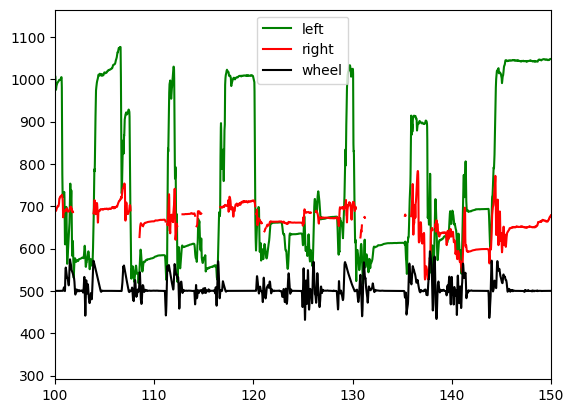

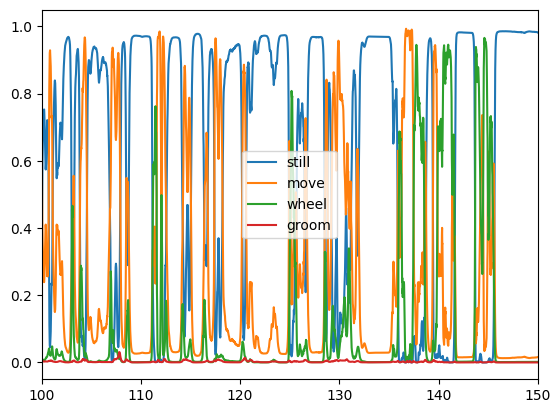

In [61]:
from matplotlib import pyplot as plt
import seaborn as sns
init = 100
end = init+50
plt.plot(times_l, l_paw_x, color='green', label='left')
plt.plot(times_l, r_paw_x, color='red', label='right')
plt.plot(wheel_t, wheel_vel*20+500, color='black', label='wheel')
plt.xlim([init, end])
plt.legend()
plt.show()
plt.plot(times_l, paws_l['paw_l_still'], label='still')
plt.plot(times_l, paws_l['paw_l_move'], label='move')
plt.plot(times_l, paws_l['paw_l_wheel_turn'], label='wheel')
plt.plot(times_l, paws_l['paw_l_groom'], label='groom')
plt.xlim([init, end])
plt.legend()
plt.show()
# plt.plot(times_l, paws_l['paw_r_still_ens_var'])
# plt.plot(times_l, paws_l['paw_r_move_ens_var'])
# plt.plot(times_l, paws_l['paw_r_wheel_turn_ens_var'])
# plt.plot(times_l, paws_l['paw_r_groom_ens_var'])
# plt.xlim([init, end])


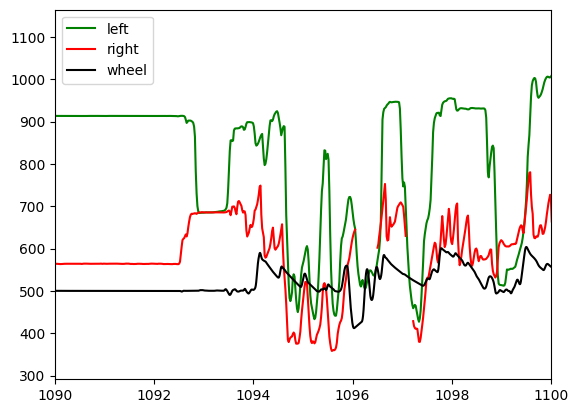

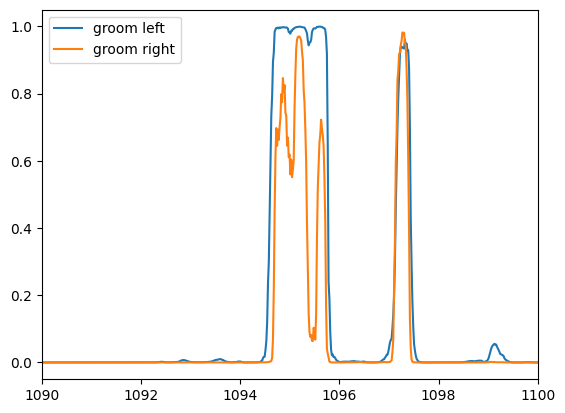

In [85]:
init = 1090
end = init+10
plt.plot(times_l, l_paw_x, color='green', label='left')
plt.plot(times_l, r_paw_x, color='red', label='right')
plt.plot(wheel_t, wheel_vel*20+500, color='black', label='wheel')
plt.xlim([init, end])
plt.legend()
plt.show()
plt.plot(times_l, paws_l['paw_l_groom'], label='groom left')
plt.plot(times_l, paws_l['paw_r_groom'], label='groom right')

plt.xlim([init, end])
plt.legend()
plt.show()

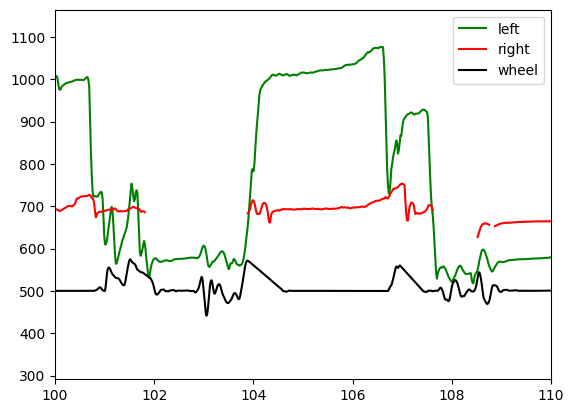

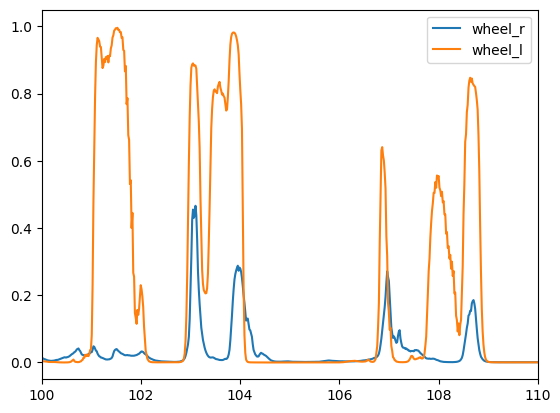

In [55]:
init = 100
end = init+10
plt.plot(times_l, l_paw_x, color='green', label='left')
plt.plot(times_l, r_paw_x, color='red', label='right')
plt.plot(wheel_t, wheel_vel*20+500, color='black', label='wheel')
plt.xlim([init, end])
plt.legend()
plt.show()

plt.plot(times_l, paws_l['paw_l_wheel_turn'], label='wheel_r')
plt.plot(times_l, paws_l['paw_r_wheel_turn'], label='wheel_l')
plt.xlim([init, end])
plt.legend()
plt.show()

In [19]:
times_l = one.load_dataset(session, '_ibl_%sCamera.times.npy' % 'left')
paws_l = one.load_dataset(session, '_ibl_%sCamera.pawstates.pqt' % 'left')


In [ ]:
plt.plot(times_l, l_paw_x, color='green')
plt.plot(times_l, r_paw_x, color='red')
plt.xlim([50, 60])

In [5]:
def process_design_matrix(session):

    file_path = one.eid2path(session)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    """ LOAD VARIABLES """
    sl = SessionLoader(eid=session, one=one)
    sl.load_pose(views=['left', 'right'], tracker='lightningPose')
    sl.load_session_data(trials=True, wheel=True, motion_energy=True)

    # Check if all data is available
    if np.sum(sl.data_info['is_loaded']) >= 4:

        # Poses
        poses = sl.pose
        lc_t = np.asarray(poses['leftCamera']['times'])
        rc_t = np.asarray(poses['rightCamera']['times'])
        left_fr = int(1/np.nanmean(np.diff(lc_t)))
        right_fr = int(1/np.nanmean(np.diff(rc_t)))
        
        # Motion energy
        me = sl.motion_energy
        mel_t = lc_t
        mer_t = rc_t
        motion_energy_l = interpolate_nans(me['leftCamera']['whiskerMotionEnergy'], left_fr)
        motion_energy_r = low_pass(interpolate_nans(me['rightCamera']['whiskerMotionEnergy'], right_fr), 
                                          cutoff=30, sf=right_fr)
        # Licks
        features = ['tongue_end_l_x', 'tongue_end_l_y', 'tongue_end_r_x', 'tongue_end_r_y']
        lick_t, licks = merge_licks(poses, features, common_fs=150)
        # Paws      
        l_paw_x = interpolate_nans(poses['leftCamera']['paw_r_x'], left_fr)
        l_paw_y = interpolate_nans(poses['leftCamera']['paw_r_y'], left_fr)
        r_paw_x = low_pass(interpolate_nans(poses['rightCamera']['paw_r_x'], right_fr), 
                                          cutoff=30, sf=right_fr)
        r_paw_y = low_pass(interpolate_nans(poses['rightCamera']['paw_r_y'], right_fr), 
                                          cutoff=30, sf=right_fr)
        l_paw_t = lc_t
        r_paw_t = rc_t
        # Wheel
        wheel = sl.wheel
        wheel_t = np.asarray(wheel['times'], dtype=np.float64)
        wheel_vel = wheel['velocity'].astype(np.float32)
        # Paw states
        if paw_states:
            times_l = one.load_dataset(session, '_ibl_%sCamera.times.npy' % 'left')
            times_r = one.load_dataset(session, '_ibl_%sCamera.times.npy' % 'right')
            assert times_l == lc_t
            assert times_r == rc_t
            paws_l = one.load_dataset(session, '_ibl_%sCamera.pawstates.pqt' % 'left')
            paws_r = one.load_dataset(session, '_ibl_%sCamera.pawstates.pqt' % 'right')


        # Common resampling window
        onset = max(lc_t.min(), rc_t.min(), wheel_t.min(), lick_t.min())
        offset = min(lc_t.max(), rc_t.max(), wheel_t.max(), lick_t.max())
        fs = 60
        ref_t = np.arange(onset, offset, 1 / fs, dtype=np.float64)

        # Restrict to time window
        def restrict(t, x):
            mask = (t >= onset) & (t <= offset)
            return t[mask], x[mask]

        mel_t, motion_energy_l = restrict(mel_t, motion_energy_l)
        mer_t, motion_energy_r = restrict(mer_t, motion_energy_r)
        wheel_t, wheel_vel = restrict(wheel_t, wheel_vel)
        l_paw_t_x, l_paw_x = restrict(l_paw_t, l_paw_x)
        l_paw_t_y, l_paw_y = restrict(l_paw_t, l_paw_y)
        r_paw_t_x, r_paw_x = restrict(r_paw_t, r_paw_x)
        r_paw_t_y, r_paw_y = restrict(r_paw_t, r_paw_y)
        lick_t, licks = restrict(lick_t, licks)


        # Resample
        mel_down, rt = resample_common_time(ref_t, mel_t, motion_energy_l, kind='linear')
        mer_down, _ = resample_common_time(ref_t, mer_t, motion_energy_r, kind='linear')
        wh_down, _ = resample_common_time(ref_t, wheel_t, wheel_vel, kind='linear')
        lk_down, _ = resample_common_time(ref_t, lick_t, licks, kind='nearest')
        lpx_down, _ = resample_common_time(ref_t, l_paw_t_x, l_paw_x, kind='linear')
        lpy_down, _ = resample_common_time(ref_t, l_paw_t_y, l_paw_y, kind='linear')
        rpx_down, _ = resample_common_time(ref_t, r_paw_t_x, r_paw_x, kind='linear')
        rpy_down, _ = resample_common_time(ref_t, r_paw_t_y, r_paw_y, kind='linear')

        # Create design matrix
        design_matrix = pd.DataFrame({
            'Bin': rt,
            'Lick count': lk_down.astype(np.int8),
            'avg_wheel_vel': wh_down,
            'whisker_me': mel_down,  # zscore(mel_down, nan_policy='omit'),
            'avg_whisker_me': np.nanmean([mel_down, mer_down], axis=0),  # zscore(np.nanmean([mel_down, mer_down], axis=0), nan_policy='omit'),
            'l_paw_x': lpx_down,
            'l_paw_y': lpy_down,
            'r_paw_x': rpx_down,
            'r_paw_y': rpy_down,
        })

        # """ LOAD TRIAL DATA """
        session_trials = sl.trials
        session_start = list(session_trials['goCueTrigger_times'])[0]
        design_matrix = design_matrix.loc[(design_matrix['Bin'] > session_start)]

        """ SAVE DATA """       
        # Save unnormalized design matrix
        filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
        design_matrix.to_parquet(filename, compression='gzip')  

        # Save trials
        filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
        session_trials.to_parquet(filename, compression='gzip')  
        
        del design_matrix, session_trials, sl
        gc.collect()

    else:
        print('Data missing for session '+session)  


def parallel_process_data(sessions, function_name):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        # Process each chunk in parallel
        executor.map(function_name, sessions)

In [6]:
for s, session in enumerate(sessions_to_process):
    process_design_matrix(session)

2026-02-17 17:45:23 INFO     one.py:1288 Loading trials data
2026-02-17 17:45:24 INFO     one.py:1288 Loading wheel data
2026-02-17 17:45:24 INFO     one.py:1288 Loading motion_energy data
2026-02-17 17:45:25 INFO     one.py:1288 Loading pupil data
2026-02-17 17:45:32 INFO     one.py:1288 Loading trials data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-17 17:45:33 INFO     one.py:1288 Loading wheel data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-19/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 9.47M/9.47M [00:02<00:00, 4.25MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-19/001/alf/_ibl_wheel.position.npy: 100%|██████████| 9.47M/9.47M [00:01<00:00, 5.61MB/s]


2026-02-17 17:45:38 INFO     one.py:1288 Loading motion_energy data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-21"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-19/001/alf/#2026-01-21#/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.37M/2.37M [00:01<00:00, 1.55MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-19/001/alf/#2026-01-26#/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.93M/5.93M [00:02<00:00, 2.86MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.AL

2026-02-17 17:45:47 INFO     one.py:1288 Loading pupil data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-02-12", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-30/2020-10-19/001/alf/#2026-02-12#/_ibl_leftCamera.features.pqt: 100%|██████████| 3.50M/3.50M [00:01<00:00, 2.02MB/s]


2026-02-17 17:45:49 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-40/2021-04-12/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 6.43M/6.43M [00:02<00:00, 2.53MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-40/2021-04-12/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 362M/362M [00:16<00:00, 22.2MB/s] 

2026-02-17 17:46:15 INFO     one.py:1288 Loading trials data


2026-02-17 17:46:15 INFO     one.py:1288 Loading wheel data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-40/2021-04-12/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 5.11M/5.11M [00:02<00:00, 2.44MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-40/2021-04-12/001/alf/_ibl_wheel.position.npy: 100%|██████████| 5.11M/5.11M [00:01<00:00, 2.74MB/s]


2026-02-17 17:46:26 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-40/2021-04-12/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.58M/2.58M [00:01<00:00, 1.74MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-40/2021-04-12/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 6.43M/6.43M [00:02<00:00, 2.66MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-40/2021-04-12/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.29M/1.29M [00:01<00:00, 653kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-40/2021-04-12/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 1.29M/1.29M [00:00<00:00, 1.92MB/s]

2026-02-17 17:46:35 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-40/2021-04-12/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 5.73M/5.73M [00:03<00:00, 1.80MB/s]


2026-02-17 17:46:39 WARNING  one.py:1292 Could not load pupil data.


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-01-21", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-21/003/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 325M/325M [00:21<00:00, 15.3MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-21/003/alf/_ibl_rightCamera.times.npy: 100%|██████████| 5.76M/5.76M [00:02<00:00, 2.00MB/s]


2026-02-17 17:47:11 INFO     one.py:1288 Loading trials data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


2026-02-17 17:47:11 INFO     one.py:1288 Loading wheel data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-21/003/alf/_ibl_wheel.position.npy: 100%|██████████| 5.23M/5.23M [00:02<00:00, 2.45MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-21/003/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 5.23M/5.23M [00:01<00:00, 3.42MB/s]


2026-02-17 17:47:16 INFO     one.py:1288 Loading motion_energy data


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-21"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-21/003/alf/#2026-01-21#/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.31M/2.31M [00:01<00:00, 1.61MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-21/003/alf/#2026-01-26#/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.76M/5.76M [00:02<00:00, 2.51MB/s]
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2026-01-26"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.AL

2026-02-17 17:47:26 INFO     one.py:1288 Loading pupil data



/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:436: ALFWarning: Multiple revisions: "2026-02-12", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/angelakilab/Subjects/NYU-47/2021-06-21/003/alf/#2026-02-12#/_ibl_leftCamera.features.pqt: 100%|██████████| 5.21M/5.21M [00:02<00:00, 2.49MB/s]


2026-02-17 17:47:29 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 90.0M/90.0M [00:07<00:00, 12.3MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.36M/1.36M [00:01<00:00, 809kB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 197M/197M [00:10<00:00, 18.6MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 3.39M/3.39M [00:02<00:00, 1.42MB/s]


2026-02-17 17:47:57 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 9.70k/9.70k [00:00<00:00, 23.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 4.91k/4.91k [00:00<00:00, 14.8kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_trials.table.pqt: 100%|██████████| 44.6k/44.6k [00:00<00:00, 93.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 4.91k/4.91k [00:00<00:00, 15.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.91k/4.91k [00:00<00:00, 13.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.interna

2026-02-17 17:48:01 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_wheel.position.npy: 100%|██████████| 3.03M/3.03M [00:01<00:00, 2.05MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 3.03M/3.03M [00:00<00:00, 3.04MB/s]


2026-02-17 17:48:05 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.36M/1.36M [00:01<00:00, 1.07MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 3.39M/3.39M [00:01<00:00, 2.18MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 679k/679k [00:00<00:00, 697kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 679k/679k [00:01<00:00, 669kB/s]

2026-02-17 17:48:13 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL015/2022-02-18/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 3.29M/3.29M [00:01<00:00, 2.16MB/s]

2026-02-17 17:48:15 WARNING  one.py:1292 Could not load pupil data.



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.72M/1.72M [00:01<00:00, 1.22MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 108M/108M [00:07<00:00, 13.6MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 244M/244M [00:15<00:00, 15.6MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 4.29M/4.29M [00:03<00:00, 1.30MB/s]


2026-02-17 17:48:49 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.14k/4.14k [00:00<00:00, 12.3kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 4.14k/4.14k [00:00<00:00, 12.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 4.14k/4.14k [00:00<00:00, 12.2kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_trials.table.pqt: 100%|██████████| 42.5k/42.5k [00:00<00:00, 92.4kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 8.16k/8.16k [00:00<00:00, 23.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internati

2026-02-17 17:48:53 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_wheel.position.npy: 100%|██████████| 7.70M/7.70M [00:02<00:00, 3.75MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 7.70M/7.70M [00:01<00:00, 6.99MB/s]


2026-02-17 17:48:58 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.72M/1.72M [00:01<00:00, 1.14MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.29M/4.29M [00:01<00:00, 2.57MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 861k/861k [00:01<00:00, 770kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 861k/861k [00:00<00:00, 1.28MB/s]

2026-02-17 17:49:05 INFO     one.py:1288 Loading pupil data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hausserlab/Subjects/PL016/2022-01-12/001/alf/_ibl_leftCamera.features.pqt: 100%|██████████| 4.02M/4.02M [00:01<00:00, 2.46MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_leftCamera.lightningPose.pqt: 100%|██████████| 119M/119M [00:05<00:00, 20.6MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.94M/1.94M [00:00<00:00, 2.04MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_rightCamera.lightningPose.pqt: 100%|██████████| 277M/277M [00:15<00:00, 18.0MB/s] 
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 4.83M/4.83M [00:03<00:00, 1.48MB/s]


2026-02-17 17:49:38 INFO     one.py:1288 Loading trials data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 6.77k/6.77k [00:00<00:00, 18.0kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_trials.table.pqt: 100%|██████████| 65.0k/65.0k [00:00<00:00, 102kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_trials.quiescencePeriod.npy: 100%|██████████| 6.77k/6.77k [00:00<00:00, 18.7kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_trials.intervals_bpod.npy: 100%|██████████| 13.4k/13.4k [00:00<00:00, 34.5kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_trials.stimOffTrigger_times.npy: 100%|██████████| 6.77k/6.77k [00:00<00:00, 17.6kB/s]
(S3) /home/ines/Downloads/ONE/alyx.international

2026-02-17 17:49:43 INFO     one.py:1288 Loading wheel data



(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 11.2M/11.2M [00:02<00:00, 4.50MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_wheel.position.npy: 100%|██████████| 11.2M/11.2M [00:02<00:00, 4.39MB/s]


2026-02-17 17:49:49 INFO     one.py:1288 Loading motion_energy data


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 1.94M/1.94M [00:01<00:00, 1.20MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 4.83M/4.83M [00:01<00:00, 2.59MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 973k/973k [00:01<00:00, 605kB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_066/2022-04-20/001/alf/bodyCamera.ROIMotionEnergy.npy: 100%|██████████| 973k/973k [00:00<00:00, 1.79MB/s]

2026-02-17 17:49:57 INFO     one.py:1288 Loading pupil data


2026-02-17 17:49:58 WARNING  one.py:1292 Could not load pupil data.


(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 1.39M/1.39M [00:01<00:00, 1.00MB/s]
(S3) /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/mrsicflogellab/Subjects/SWC_039/2020-09-09/001/alf/_ibl_leftCamera.lightningPose.pqt:  62%|██████▏   | 56.9M/91.4M [00:02<00:01, 34.3MB/s]